In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# for CVXPY implementation
from solardatatools.signal_decompositions import l2_l1d1_l2d2p365 as cvx_sd
from solardatatools.algorithms import TimeShift

# for OSD implementation
import cvxpy as cvx
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from solardatatools.solar_noon import energy_com, avg_sunrise_sunset
from solardatatools.osd_signal_decompositions import l2_l1d1_l2d2p365 as osd_sd

In [2]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

input_power_signals_file_path = Path(fixtures_path + "time_shifts/two_year_signal_with_shift.csv")
with open(input_power_signals_file_path) as file:
    power_data_matrix = np.loadtxt(file, delimiter=",")

use_days_file_path = Path(fixtures_path + "time_shifts/clear_days.csv")
with open(use_days_file_path) as file:
    use_days = np.loadtxt(file, delimiter=",")

output_power_signals_file_path = Path(fixtures_path + "time_shifts/two_year_signal_fixed.csv")
with open(output_power_signals_file_path) as file:
    expected_power_data_fix = np.loadtxt(file, delimiter=",")

In [3]:
##### CVXPY
cvx_time_shift_analysis = TimeShift()
cvx_time_shift_analysis.run(power_data_matrix, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data

np.testing.assert_almost_equal(cvx_actual_power_data_fix, expected_power_data_fix, decimal=0.2)

/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/algorithms/time_shifts.py:121: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0


In [20]:
### Define OSD class/function (reference right fn and update arg names, keeping c1 vals the same)

class TimeShiftOSD:
    def __init__(self):
        self.metric = None
        self.s1 = None
        self.s2 = None
        self.index_set = None
        self.corrected_data = None
        self.roll_by_index = None
        self.normalized_holdout_error = None
        self.normalized_train_error = None
        self.tv_metric = None
        self.jumps_per_year = None
        self.best_c1 = None
        self.best_ix = None
        self.__recursion_depth = 0

    def run(
        self,
        data,
        use_ixs=None,
        c1=None,
        c2=200.0,
        solar_noon_estimator="com",
        threshold=0.1,
        periodic_detector=False,
        solver=None,
    ):
        if solar_noon_estimator == "com":
            metric = energy_com(data)
        elif solar_noon_estimator == "srss":
            metric = avg_sunrise_sunset(data, threshold=threshold)
        self.metric = metric
        if use_ixs is None:
            use_ixs = ~np.isnan(metric)
        else:
            use_ixs = np.logical_and(use_ixs, ~np.isnan(metric))
        self.use_ixs = use_ixs
        # Optimize c1
        if c1 is None:
            c1s = np.logspace(-1, 2, 11)
            hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
                metric, c1s, use_ixs, c2, periodic_detector, solver=solver
            )
            if tv_metric[best_ix] >= 0.009:
                # rerun the optimizer with a new random data selection
                hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
                    metric, c1s, use_ixs, c2, periodic_detector, solver=solver
                )
            # if np.isclose(hn[best_ix], hn[-1]):
            #     best_ix = np.argmax(hn * rn)
            best_c1 = c1s[best_ix]
        else:
            best_c1 = c1
            hn = None
            rn = None
            tv_metric = None
            jpy = None
            c1s = None
            best_ix = None
        s1, s2 = self.estimate_components(
            metric, best_c1, c2, use_ixs, periodic_detector, solver=solver
        )
        # find indices of transition points
        index_set = np.arange(len(s1) - 1)[np.round(np.diff(s1, n=1), 3) != 0]
        # print(len(index_set), len(index_set) / (len(metric) / 365))
        s1, s2 = self.estimate_components(
            metric,
            best_c1,
            c2,
            use_ixs,
            periodic_detector,
            transition_locs=index_set,
            solver=solver,
        )
        jumps_per_year = len(index_set) / (len(metric) / 365)
        cond1 = jumps_per_year >= 5
        cond2 = c1 is None
        cond3 = self.__recursion_depth < 2
        if cond1 and cond2 and cond3:
            # Unlikely that  there are more than 5 time shifts per year. Try a
            # different random sampling
            self.__recursion_depth += 1
            self.run(
                data,
                use_ixs=use_ixs,
                c1=c1,
                c2=c2,
                solar_noon_estimator=solar_noon_estimator,
                threshold=threshold,
                periodic_detector=periodic_detector,
                solver=solver,
            )
            return
        # Apply corrections
        roll_by_index = np.round(
            (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0
        )
        correction_metric = np.average(np.abs(roll_by_index))
        if correction_metric < 0.01:
            roll_by_index[:] = 0
        self.roll_by_index = roll_by_index
        index_set = np.arange(len(roll_by_index) - 1)[
            np.round(np.diff(roll_by_index, n=1), 3) != 0
        ]
        Dout = self.apply_corrections(data)

        # save results
        self.normalized_holdout_error = hn
        self.normalized_train_error = rn
        self.tv_metric = tv_metric
        self.jumps_per_year = jpy
        self.c1_vals = c1s
        self.best_c1 = best_c1
        self.best_ix = best_ix
        self.s1 = s1
        self.s2 = s2
        self.index_set = index_set
        self.corrected_data = Dout
        self.__recursion_depth = 0

    def optimize_c1(self, metric, c1s, use_ixs, c2, periodic_detector, solver=None):
        # set up train/test split with sklearn
        ixs = np.arange(len(metric))
        ixs = ixs[use_ixs]
        train_ixs, test_ixs = train_test_split(ixs, test_size=0.85)
        train = np.zeros(len(metric), dtype=bool)
        test = np.zeros(len(metric), dtype=bool)
        train[train_ixs] = True
        test[test_ixs] = True
        # initialize results objects
        train_r = np.zeros_like(c1s)
        test_r = np.zeros_like(c1s)
        tv_metric = np.zeros_like(c1s)
        jpy = np.zeros_like(c1s)
        # iterate over possible values of c1 parameter
        c1s=[100]
        for i, v in enumerate(c1s):
            s1, s2 = self.estimate_components(
                metric, v, c2, train, periodic_detector, n_iter=5, solver=solver
            )
            y = metric
            # collect results
            train_r[i] = np.average(np.power((y - s1 - s2)[train], 2))
            test_r[i] = np.average(np.power((y - s1 - s2)[test], 2))
            tv_metric[i] = np.average(np.abs(np.diff(s1, n=1)))
            count_jumps = np.sum(~np.isclose(np.diff(s1), 0, atol=1e-4))
            jumps_per_year = count_jumps / (len(metric) / 365)
            jpy[i] = jumps_per_year

        def zero_one_scale(x):
            return (x - np.min(x)) / (np.max(x) - np.min(x))

        hn = zero_one_scale(test_r)  # holdout error metrix
        rn = zero_one_scale(train_r)
        ixs = np.arange(len(c1s))
        # Detecting more than 5 time shifts per year is extremely uncommon,
        # and is considered non-physical
        slct = np.logical_and(jpy <= 5, hn <= 0.02)
        # slct = np.logical_and(slct, rn < 0.9)
        best_ix = 0 # np.nanmax(ixs[slct])
        return hn, rn, tv_metric, jpy, best_ix

    def estimate_components(
        self,
        metric,
        c1,
        c2,
        use_ixs,
        periodic_detector,
        transition_locs=None,
        n_iter=5,
        solver=None,
    ):
        # Iterative reweighted L1 heuristic
        w = np.ones(len(metric) - 1)
        eps = 0.1
        #for i in range(n_iter): # set this to 1
        c1 = 100
        for i in range(1):
            #print(repr(metric))
            # print(repr(w))
            # print(repr(use_ixs))
            # print(repr(periodic_detector))
            # print(repr(transition_locs))
            print(c1)
            #################################################################################
            s1, s2 = osd_sd(
                metric,
                #w1=100,
                w1=c1,
                w2=c2,
                tv_weights=w, # do not use this to compare first pass
                use_ixs=use_ixs,
                yearly_periodic=periodic_detector,
                transition_locs=transition_locs,
                #seas_max=None,
                solver=solver,
            )
            #################################################################################
            w = 1 / (eps + np.abs(np.diff(s1, n=1)))
       
        # print(repr(s1))
        # print(repr(s2))
        return s1, s2

    def plot_analysis(self, figsize=None):
        if self.metric is not None:
            import matplotlib.pyplot as plt

            fig = plt.figure(figsize=figsize)
            plt.plot(self.metric, linewidth=1, label="metric")
            plt.plot(self.s1, label="shift detector")
            plt.plot(self.s1 + self.s2, ls="--", label="SD model")
            plt.legend()
            plt.xlabel("day number")
            plt.ylabel("solar noon [hours]")
            return fig

    def plot_optimization(self, figsize=None):
        if self.best_ix is not None:
            c1s = self.c1_vals
            hn = self.normalized_holdout_error
            rn = self.normalized_train_error
            best_c1 = self.best_c1
            import matplotlib.pyplot as plt

            fig, ax = plt.subplots(nrows=4, sharex=True, figsize=figsize)
            ax[0].plot(c1s, hn, marker=".")
            ax[0].axvline(best_c1, ls="--", color="red")
            ax[0].set_title("holdout validation")
            ax[1].plot(c1s, self.jumps_per_year, marker=".")
            ax[1].axvline(best_c1, ls="--", color="red")
            ax[1].set_title("jumps per year")
            ax[2].plot(c1s, rn, marker=".")
            ax[2].axvline(best_c1, ls="--", color="red")
            ax[2].set_title("training residuals")
            ax[3].plot(c1s, self.tv_metric, marker=".")
            ax[3].axvline(best_c1, ls="--", color="red")
            ax[3].set_xscale("log")
            ax[3].set_title("Total variation metric")
            plt.tight_layout()
            return fig

    def apply_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, int(roll), axis=0)[:, ixs]
        return Dout

    def invert_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, -int(roll), axis=0)[:, ixs]
        return Dout

In [21]:
# ##### OSD -- takes a long time to run
# osd_time_shift_analysis = TimeShiftOSD()
# osd_time_shift_analysis.run(power_data_matrix, use_ixs=use_days, solver="MOSEK")
# osd_actual_power_data_fix = osd_time_shift_analysis.corrected_data

In [22]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSD()
qosd_time_shift_analysis.run(power_data_matrix, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data

100
100
100


/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_16577/2173630246.py:98: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0


In [23]:
np.testing.assert_almost_equal(cvx_actual_power_data_fix, qosd_actual_power_data_fix, decimal=1)
plt.plot(qosd_actual_power_data_fix.flatten(), linewidth=0.5, alpha=0.5)
plt.plot(cvx_actual_power_data_fix.flatten(), linewidth=0.5, alpha=0.5)

AssertionError: 
Arrays are not almost equal to 1 decimals

Mismatched elements: 7286 / 70080 (10.4%)
Max absolute difference: 6.92149057
Max relative difference: 1190.07074614
 x: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...
 y: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...

## Printed some of the data to look at what OSD is doing

In [5]:
metric = np.array([12.36774135, 13.2664748 , 12.56132334, 12.52445417, 12.52229442,
       12.56408635, 12.4911395 , 12.51665877, 12.53024823, 12.7799635 ,
       12.06189556, 12.69771658, 12.62526889, 12.63455797, 12.63062649,
       12.81117907, 12.57886281, 12.6695477 , 12.36070833, 12.68027906,
       12.65093609, 12.6193332 , 12.7227687 , 12.5413301 , 11.69634835,
       12.65671163, 12.6998848 , 12.74090381, 12.74037252, 12.87396833,
       12.73492581, 12.88181244, 12.75082204, 12.7734351 , 12.71982865,
       12.77258883, 12.84717796, 12.83679262, 12.80252855, 12.77973464,
       12.7137747 , 12.79554686, 12.83010745, 12.86288315, 12.81277058,
       12.8328108 , 12.79812722, 12.85398738, 12.65189048, 12.82383025,
       12.8162408 , 12.81221743, 12.81833707, 12.84622721, 12.83531618,
       12.82107318, 12.56804966, 12.82073844, 12.61801084, 13.13976051,
       12.6010538 , 12.80096983, 12.84011398, 12.63085248, 12.82827425,
       12.81898654, 12.83126234, 12.77669286, 12.82128021, 12.81805235,
       12.84232068,         np.nan, 12.66958219, 12.83462937, 12.817071  ,
       12.79027   , 12.78958885, 12.76839185, 12.75462606, 12.75662561,
       12.94562348, 12.67777452, 12.8398068 , 12.72043994, 13.25576609,
       12.88247277, 12.81879342, 12.53069192, 12.67675728, 12.76922903,
       13.09436299, 12.36246512, 12.64694954, 12.77058825, 12.61400959,
       12.55189493, 12.16795347, 12.70341632, 12.92993754, 12.69399833,
       12.70046403, 12.67778722, 12.66969642, 12.65603167, 12.61669252,
       12.64482451, 12.20310886, 12.68373107, 12.6239453 , 12.54703884,
       12.60588552, 12.36929638, 12.59332538, 12.63121563, 12.58194663,
       12.61027615, 12.64082843, 12.74430664, 12.61180949, 12.5746527 ,
       12.24731817, 13.29250313, 12.5818517 , 12.48612456, 12.60034463,
       12.56695748, 12.20538211, 12.56227804, 12.35451469, 12.51338877,
       12.50078889, 12.69796049, 12.53862407, 12.50445922, 12.60149357,
       12.19073796, 12.41492021, 12.14310407, 12.53040809, 12.48790508,
       12.47823143, 12.55925175, 12.58562829, 12.43268262, 12.49649846,
       12.48395945, 12.43573792, 12.47512127, 12.47034179, 12.49116665,
       12.47249083, 12.47710647, 12.48435135, 12.4692007 , 12.49351333,
       12.48915518, 12.59921364, 12.47249121, 12.4699365 , 12.48466321,
       12.46918678, 12.45284257, 12.47639202, 11.4855838 , 11.47352742,
       11.50008569, 11.4931678 , 11.47682354, 11.54368171, 11.48506623,
       11.49669613, 11.51613563, 11.489753  , 11.49767741, 11.50845193,
       11.49664564, 11.49310081, 11.52593209, 11.44770576, 11.53244069,
       11.58973714, 10.82910381, 12.32576184, 11.53362861, 11.54815201,
       11.53327206, 11.53687593, 11.52499001, 11.546445  , 11.58851154,
       11.5653937 , 11.56478677, 11.56611105, 11.56067651, 11.55179465,
       11.56582683, 11.58986675, 11.58596998, 11.57750035, 11.60144973,
       11.65024373, 11.59839067, 11.59886959, 11.61951181, 11.85824306,
       11.63893115, 12.05193568, 11.64294135, 11.60511827, 11.64111761,
       11.61862977, 12.86961601, 11.90711359, 12.45026402, 12.58816168,
       11.6343981 , 11.62363436, 12.1553475 , 11.65757708, 11.64176216,
       11.5575469 , 11.61555845, 11.80649607, 11.74667187, 11.67036166,
       11.89161754, 11.65399189, 11.50094539, 11.68653658, 11.616421  ,
       11.67157529, 11.638202  , 11.65325229, 11.62850978, 11.62887115,
       11.6864374 , 11.67625951, 11.63840528, 12.26094906, 11.61442579,
       11.81525043, 11.65858899, 11.65351565, 11.07144304, 11.60439065,
       11.65278823, 11.61701912, 11.56119215, 11.638673  , 11.64655849,
       11.59322152, 11.69601222, 11.60994224, 11.61136929, 11.57902741,
       11.5453805 , 11.61026155, 11.58906641, 11.57972018, 11.57378067,
       11.68537091, 11.47622599, 11.525345  , 11.55096816, 11.55985764,
       11.54349862, 11.52269633, 11.52884335, 11.52360837, 11.52231975,
       11.49874266, 11.51004235, 11.48277631, 11.52259817, 11.52548236,
       11.4956226 , 11.48021916, 11.6966361 , 11.38813621, 11.48115104,
       11.44450733, 11.41101055, 11.48174081, 11.42939372, 11.43085384,
       11.43165085, 11.43675483, 11.40837812, 10.3590913 , 10.3651215 ,
       11.6825812 , 11.54975301, 11.39503661, 11.40032605, 11.26994505,
       11.30317076, 11.41774734, 11.37123387, 11.33314033, 11.29101359,
       12.13869645, 10.89106482, 11.2922039 , 11.36063732, 11.36542024,
       11.34699644, 11.34974845, 11.34722523, 11.31419301, 11.33861519,
       11.06970753, 11.36342339, 11.364153  , 11.29050426, 11.30638746,
       11.29265521, 11.15058632, 11.10282939, 11.35392889, 11.38308001,
       11.2857083 , 11.29086459, 11.31829635, 11.2472528 , 11.29949843,
       11.31610736, 11.30452529, 11.37802691, 11.35428542, 11.3148809 ,
       11.44196369, 11.33337106, 11.28378694, 11.76138745, 11.24035056,
       11.27157276, 11.28720617, 11.37971962, 11.32259553, 11.46611992,
       11.34009091, 11.55069726, 11.41108833, 11.36612395, 11.34597759,
       11.39612655, 11.36440629, 11.42429571, 11.5658823 , 11.36651233,
       11.40163781, 11.47267733, 11.42373599, 11.28970551, 11.4556638 ,
       11.11283427, 11.52111686, 11.46288073, 11.46302055, 11.41831312,
       11.45619994, 11.58685652, 11.50329854, 11.44184364, 11.64407172,
       12.00645964, 11.62600458, 11.50557572, 11.68547836, 11.64110306,
       11.36647708, 11.53369795, 11.40230789, 11.58702647, 11.47681043,
       11.61528582, 11.66510575, 11.62698578, 11.62510206, 11.62098461,
       10.49800821, 11.64919584, 11.66510286, 11.66622009, 11.66668752,
       10.65791604, 11.85261343, 11.71028734, 11.63905049, 11.64534631,
       11.74373996, 11.49263595, 12.01552317, 11.51666582, 11.11012973,
       12.57382305, 11.93437631, 11.460113  , 11.54068168, 11.78515088,
       11.52583163, 11.8807411 , 11.81448175, 11.79526047, 11.62092451,
       11.80569396, 11.77809079, 11.83168419, 11.59546499, 11.68648158,
       11.73465697, 12.11757353, 11.72521454, 11.45527258, 11.82404741,
       11.81038044, 11.76788834, 11.84162127, 11.82070584, 11.81051408,
       12.05985756, 11.82890909, 11.83791624, 11.65479445, 11.93664228,
       12.23525577, 11.45239787, 11.88393261, 11.79669205, 11.79908649,
       11.8360067 , 11.48267674, 11.74801788, 12.11278233, 11.81628356,
       11.83046238, 11.71522363, 11.21185594, 11.90534064, 11.78978942,
       11.7526011 , 12.49929101, 11.7757398 , 11.65308463, 11.72492241,
       11.76521135, 11.64955445, 11.90190532, 11.45859437, 11.33686855,
       10.6991412 , 12.19309698, 11.77263263, 11.74925908, 11.79458624,
       11.71104372, 11.72289402, 11.69496713, 11.72992446, 12.01503995,
       11.75723286, 11.69377943, 11.69550761, 11.64699401, 11.68082302,
       11.43234823, 11.34788581, 11.66478959, 11.67312389, 11.68149516,
       11.66353337, 11.6040666 , 11.60148051, 11.57329495, 11.92373854,
       11.510058  , 11.50597493, 11.5051059 , 11.40305778, 11.41399655,
       11.60155767, 11.3966928 , 11.56458649, 11.5892734 , 11.47591767,
       11.1137423 , 12.63668109, 11.60582609, 11.54975349, 11.53774862,
       11.55123084, 11.56392552, 11.36566908, 11.55920569, 11.53363533,
       11.52488578, 11.53193989, 11.50448488, 11.12940227, 11.59327134,
       11.5233809 , 11.47658154, 11.45273397, 11.51767838, 11.5194423 ,
       11.47901027,         np.nan,         np.nan,         np.nan,         np.nan,
               np.nan,         np.nan,         np.nan,         np.nan,         np.nan,
               np.nan,         np.nan,         np.nan,         np.nan,         np.nan,
               np.nan,         np.nan,         np.nan,         np.nan,         np.nan,
               np.nan,         np.nan, 11.46510981, 11.48883244, 11.46096089,
       11.48538786, 11.49127595, 11.46937783, 11.47621082, 11.47442448,
       11.46716744, 11.48649814, 11.49676548, 11.47680011, 11.48099795,
       11.51371985, 11.43003099, 11.31875585, 11.51854904, 11.84380692,
       11.47832032, 11.51087089, 11.48959386, 11.51817487, 11.51862534,
       11.51487872, 11.51263142, 11.52423197, 11.49383152, 11.548535  ,
       11.52146171, 11.61412371, 11.59608213, 11.54034954, 11.25640791,
       11.53849162, 11.61351845, 11.57024481, 11.58651216, 11.60111868,
       11.56312942, 11.58157697, 11.57326643, 11.6594092 , 11.57841484,
       11.57489146, 11.58508642, 10.64825319, 11.58359553, 11.61814568,
       11.73158567, 11.63265734, 11.60905163, 11.66803481, 11.63218353,
       11.60795781, 11.59521619, 11.52950913, 11.78900977, 11.60374177,
       12.75430202, 11.58641454, 11.6296947 , 11.65970961, 11.65925241,
       11.37288885, 11.10762348, 12.02525184, 11.63665049, 11.72507111,
       11.53911496, 11.64468267, 11.45343665, 11.72986976, 11.53687343,
       11.64729638, 11.64312605, 11.68442794, 11.63514529, 11.61275899,
       11.6003958 , 11.63438522, 11.63151616, 11.63531433, 11.46990599,
       11.58329153, 11.61117144, 11.64778769, 11.60735953, 11.65091232,
       11.62717243, 11.71582396, 11.57900668, 11.60290395, 11.60659204,
       11.60243048, 11.58520625, 11.59528491, 11.5400697 , 11.57532857,
       11.48338394, 11.5705933 , 11.52631066, 11.54343924, 11.55869831,
       11.55364537, 11.83295514, 11.71935491, 11.56041466, 11.53281497,
       11.50456751, 11.26106713, 11.46245097, 11.44931946, 11.62257339,
       11.51573509, 11.51448983, 11.43540795, 11.4688628 , 11.46489999,
       11.42653805, 11.58782008, 11.1203873 , 10.23163473, 12.016667  ,
       11.42889561, 11.48364606, 11.4392621 , 11.42943987, 11.38576823,
       11.37959391, 11.39292575, 11.38845385, 11.38573619, 11.40797418,
       11.37003971, 11.37776836, 11.36873977, 11.46640837, 11.35969279,
       11.35072264, 11.34430526, 11.54491104, 11.34568385, 11.32375222,
       11.31691193, 11.3873715 , 11.32756488, 11.36492376, 11.33933116,
       11.32951635, 11.32617606, 11.35502679, 11.33089331, 11.29515322,
       11.16202441, 11.34265848, 11.28301085, 11.44684908, 11.3074192 ,
       11.29185502, 11.30108665, 11.29386721, 11.28393585, 11.29662015,
       11.30349083, 11.27847524, 11.30682002, 11.24915982, 11.66545281,
       11.3160556 , 11.30813291, 11.26753188, 11.3012811 , 11.31460878,
       11.42190471, 11.3387775 , 11.0700295 , 12.12822269, 11.05813199,
       11.62601652, 11.31897536, 11.56406821, 11.36222698, 11.63349318,
       11.36512458, 11.32486272, 11.415598  , 11.27849965, 11.28728224,
       11.39936633, 11.82329613, 10.98401015, 10.96530111, 11.46859802,
       11.45724434, 10.5011793 , 11.76848836, 11.49039782, 11.34179344,
       11.45408941, 11.46133761, 11.48009038, 11.35404307, 11.50462654])

w = np.array([9.99930251, 9.9986177 , 9.998101  , 9.99765771, 9.99725572,
       9.99687143, 9.9965055 , 9.99614261, 9.99578193, 9.99539958,
       9.99509302, 9.99472855, 9.99437782, 9.99403333, 9.99369703,
       9.99335151, 9.99303977, 9.99273029, 9.99246315, 9.9921759 ,
       9.99190375, 9.99164812, 9.99139567, 9.99117492, 9.99105296,
       9.99085139, 9.99066255, 9.99048689, 9.99032802, 9.99017228,
       9.99004644, 9.98992012, 9.98981976, 9.98972997, 9.98965874,
       9.98959578, 9.98953917, 9.98949701, 9.98947118, 9.98946016,
       9.98946819, 9.98948036, 9.98950106, 9.98953006, 9.98957539,
       9.98962971, 9.98969788, 9.98977002, 9.98987163, 9.98996576,
       9.99007028, 9.99018451, 9.99030698, 9.99043489, 9.9905714 ,
       9.99071612, 9.99089221, 9.99104909, 9.99123213, 9.99136887,
       9.99156408, 9.99174288, 9.99192051, 9.9921202 , 9.9922991 ,
       9.99247445, 9.99263963, 9.9927964 , 9.99292966, 9.99304026,
       9.99312632, 9.99448258, 9.99458465, 9.99469247, 9.99482602,
       9.99498292, 9.99515483, 9.99533714, 9.99552394, 9.99571011,
       9.99587457, 9.99606134, 9.99622683, 9.99639891, 9.99651286,
       9.99666033, 9.99681189, 9.99698999, 9.99715128, 9.99730087,
       9.99741488, 9.99759824, 9.99774946, 9.99788462, 9.99803143,
       9.99818017, 9.9983633 , 9.99848968, 9.99859032, 9.99871114,
       9.99882781, 9.9989436 , 9.99905755, 9.99917026, 9.99928412,
       9.99939225, 9.99954165, 9.99964058, 9.99974305, 9.99985045,
       9.99994872, 9.99993255, 9.99983876, 9.99975069, 9.99965891,
       9.99957059, 9.99948563, 9.99941102, 9.99932316, 9.99923152,
       9.99910694, 9.99908693, 9.99899891, 9.998906  , 9.99882971,
       9.99875523, 9.99864909, 9.99858188, 9.99849592, 9.99842692,
       9.99835723, 9.99830766, 9.99824277, 9.9981751 , 9.99811759,
       9.99802013, 9.99794732, 9.99785265, 9.99780907, 9.99778789,
       9.9978093 , 9.99788568, 9.99800757, 9.99813916, 9.99828607,
       9.9984307 , 9.99856295, 9.99868622, 9.99879084, 9.9988736 ,
       9.99892392, 9.99893626, 9.99890181, 9.99880818, 9.99864889,
       9.99841268, 9.99811355, 9.99777699, 9.99762292, 9.99821283,
       9.99977444, 9.99751001, 1.10216444, 4.27780787, 6.10889562,
       7.44057455, 9.99895729, 9.99935774, 9.99946771, 9.99928214,
       9.99900091, 9.99873723, 9.99852657, 9.99836526, 9.99824529,
       9.99816065, 9.9981033 , 9.99806383, 9.99804881, 9.99803813,
       9.99803117, 9.99810742, 9.99803999, 9.99805548, 9.99807183,
       9.99809114, 9.99811112, 9.99813319, 9.998154  , 9.99817152,
       9.99819222, 9.99821375, 9.99823583, 9.99825923, 9.99828473,
       9.99831087, 9.9983372 , 9.99836677, 9.9984002 , 9.9984344 ,
       9.998467  , 9.99850822, 9.99855306, 9.99859979, 9.99862682,
       9.99868022, 9.99869761, 9.99876236, 9.99883894, 9.99891545,
       9.99897433, 9.99882757, 9.99864511, 9.99850223, 8.61047285,
       9.99864341, 9.99894053, 9.99927484, 9.99952167, 9.99968213,
       9.99982311, 9.9999535 , 9.99993397, 9.99981337, 9.99968325,
       9.99957345, 9.99943783, 9.99928426, 9.99914683, 9.99900036,
       9.99885772, 9.99871016, 9.99856245, 9.99841033, 9.99825618,
       9.99810558, 9.99795196, 9.99779307, 9.99769592, 9.99753527,
       9.99739675, 9.99724529, 9.99709614, 9.99689109, 9.99674024,
       9.99659416, 9.99644397, 9.99628756, 9.99613835, 9.99598972,
       9.99583604, 9.99569344, 9.99554368, 9.99539584, 9.99524675,
       9.99509633, 9.99495444, 9.99481252, 9.99467178, 9.99453254,
       9.99440648, 9.99426147, 9.99412306, 9.99398863, 9.99385646,
       9.9937242 , 9.99359189, 9.99346311, 9.99333748, 9.99321575,
       9.99309564, 9.9929802 , 9.99286486, 9.99275584, 9.9926494 ,
       9.99254268, 9.99243766, 9.99235814, 9.99225249, 9.99216132,
       9.99207211, 9.99198542, 9.99191164, 9.99183764, 9.99176746,
       9.99170178, 9.99164194, 9.99158519, 9.99142911, 9.99127676,
       9.99125685, 9.99122439, 9.99117781, 9.99113381, 9.9910794 ,
       9.99103118, 9.99099737, 9.99096205, 9.99092629, 9.99089002,
       9.99094256, 9.99087579, 9.99085413, 9.99084433, 9.99083997,
       9.99083863, 9.99084236, 9.99085072, 9.99086073, 9.99087815,
       9.99087365, 9.9909031 , 9.99093733, 9.99096912, 9.9910075 ,
       9.99104935, 9.9910814 , 9.9911126 , 9.99117245, 9.99123906,
       9.99130013, 9.99136602, 9.99143896, 9.99150898, 9.99158809,
       9.99167244, 9.99175896, 9.99185594, 9.99195371, 9.99205089,
       9.99216472, 9.99227203, 9.99237871, 9.99253727, 9.99264814,
       9.99276605, 9.99288886, 9.99302362, 9.99315502, 9.99330376,
       9.9934431 , 9.99360705, 9.99376104, 9.9939149 , 9.9940712 ,
       9.99423713, 9.99440437, 9.99458192, 9.99477804, 9.99495902,
       9.9951488 , 9.99535193, 9.9955578 , 9.99575814, 9.99598262,
       9.99618023, 9.99642483, 9.9966671 , 9.99690945, 9.9971409 ,
       9.99735879, 9.99755654, 9.99769208, 9.9977436 , 9.99771462,
       9.99759696, 9.99734437, 9.99700771, 9.99664206, 9.99624636,
       9.99581365, 9.99539865, 9.99497775, 9.99458563, 9.99419413,
       9.99382838, 9.99347898, 9.99313719, 9.9928069 , 9.99248814,
       9.99206904, 9.99177569, 9.99149473, 9.99122522, 9.99096745,
       9.99062091, 9.99040488, 9.99018627, 9.98997255, 9.98977097,
       9.98958925, 9.98939201, 9.98925646, 9.98908135, 9.98887627,
       9.98882831, 9.98872948, 9.98859747, 9.98848758, 9.9884156 ,
       9.98833072, 9.98829368, 9.98826249, 9.98824196, 9.98821656,
       9.98822171, 9.98823584, 9.98826681, 9.9882855 , 9.98832413,
       9.98837809, 9.98848064, 9.98855452, 9.98861142, 9.98871383,
       9.98882285, 9.98893504, 9.98906158, 9.98919278, 9.98932953,
       9.98949752, 9.9896486 , 9.9898059 , 9.98994943, 9.9901248 ,
       9.99033391, 9.99046905, 9.99065136, 9.99082979, 9.99101467,
       9.99121203, 9.99138656, 9.99160418, 9.99187927, 9.99214902,
       9.99244287, 9.9927376 , 9.99297021, 9.99324855, 9.99348954,
       9.99370382, 9.9939749 , 9.99416217, 9.99433038, 9.99450214,
       9.99467637, 9.99483881, 9.99502659, 9.99517023, 9.99530097,
       9.99536623, 9.99557735, 9.99574293, 9.99590253, 9.99606323,
       9.99621274, 9.99636131, 9.9965049 , 9.99664983, 9.99682145,
       9.99696587, 9.99710232, 9.99723663, 9.99736378, 9.99749243,
       9.9975946 , 9.99768645, 9.99780776, 9.99792777, 9.9980468 ,
       9.99816252, 9.99827089, 9.99837724, 9.99847919, 9.99861504,
       9.99870901, 9.99880209, 9.99889409, 9.99897436, 9.9990536 ,
       9.99914894, 9.9992209 , 9.99930652, 9.99939155, 9.99946215,
       9.99949334, 9.99967392, 9.99975154, 9.9998253 , 9.99990016,
       9.99997858, 9.99994015, 9.99987841, 9.99979825, 9.99972256,
       9.99965018, 9.99957972, 9.99951441, 9.99948872, 9.99941737,
       9.99934576, 9.99924393, 9.99904443, 9.99869812, 9.99849575,
       0.10236189, 9.99848867, 9.99868058, 9.99901824, 9.99921893,
       9.99932582, 9.9994075 , 9.99949578, 9.99960323, 9.99973712,
       9.99990432, 9.99988738, 9.99962906, 9.9993111 , 9.99892582,
       9.99847921, 9.99803931, 9.9978861 , 9.99874665, 9.99865516,
       9.99655186, 0.10375963, 9.99739946, 9.9998206 , 9.99675231,
       9.99560128, 9.99559272, 9.99594323, 9.99633045, 9.99666059,
       9.99691705, 9.99710728, 9.99724016, 9.99732318, 9.99736867,
       9.99738823, 9.99737761, 9.99733994, 9.99731095, 9.99730708,
       9.99726276, 9.99722012, 9.99717509, 9.99713491, 9.99709824,
       9.99706555, 9.99703747, 9.99701554, 9.99699559, 9.99698612,
       9.99697902, 9.99698633, 9.99699707, 9.99700737, 9.99699395,
       9.99701252, 9.99704179, 9.99706963, 9.99710177, 9.99713783,
       9.99717236, 9.99721076, 9.99725002, 9.9972992 , 9.99734128,
       9.9973836 , 9.99742652, 9.9973738 , 9.99740942, 9.99744109,
       9.99747589, 9.99749443, 9.99751113, 9.99754677, 9.99760783,
       9.99770032, 9.99782213, 9.99795348, 9.99811587, 9.99825978,
       9.9985173 , 9.99865756, 9.99880211, 9.99895012, 9.99909888,
       9.99921983, 9.99931473, 9.99950112, 9.99964853, 9.99980489,
       9.999943  , 9.99990806, 9.99977817, 9.99962102, 9.99948381,
       9.99933651, 9.99919054, 9.99904099, 9.99889609, 9.99875171,
       9.99860608, 9.99845408, 9.99829949, 9.99814234, 9.99800106,
       9.99784897, 9.99769526, 9.99753935, 9.99738901, 9.9972357 ,
       9.99708583, 9.99692782, 9.99678375, 9.99663739, 9.99649075,
       9.99634471, 9.99620076, 9.99605629, 9.99591797, 9.99577695,
       9.99564617, 9.99550799, 9.99537596, 9.99524436, 9.99511361,
       9.99498571, 9.99483193, 9.99469079, 9.99456621, 9.99444486,
       9.99432701, 9.99423472, 9.99412444, 9.99401819, 9.99389756,
       9.99379024, 9.99368529, 9.99358994, 9.99349231, 9.99339574,
       9.99330335, 9.99319508, 9.99313385, 9.9931627 , 9.99301604,
       9.99293019, 9.99284019, 9.99275545, 9.99267312, 9.99259895,
       9.99253153, 9.9924692 , 9.9924132 , 9.99236273, 9.99231482,
       9.9922753 , 9.99223959, 9.99220925, 9.99217352, 9.9921525 ,
       9.99213603, 9.99212287, 9.99209259, 9.99208518, 9.99208309,
       9.99208497, 9.99208321, 9.99209078, 9.99209798, 9.99211109,
       9.99212865, 9.99215033, 9.99217288, 9.99220141, 9.99223705,
       9.9922897 , 9.99232851, 9.99237798, 9.99241613, 9.99247301,
       9.99253594, 9.99260232, 9.9926738 , 9.9927508 , 9.99283137,
       9.99291638, 9.99300927, 9.9931049 , 9.99321183, 9.99328252,
       9.9933928 , 9.99350821, 9.99363197, 9.99375676, 9.99388445,
       9.99400603, 9.99414106, 9.99430866, 9.99437662, 9.99455679,
       9.99468534, 9.99484918, 9.9949927 , 9.99516008, 9.99530387,
       9.99547776, 9.99565897, 9.99583448, 9.99602684, 9.99622099,
       9.99640598, 9.99654955, 9.99677641, 9.99700418, 9.99718083,
       9.9973578 , 9.99763053, 9.99777931, 9.99796192, 9.99817203,
       9.99839568, 9.99866335, 9.99900279, 9.99945625])
use_ixs = np.array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False,  True, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

# resulting last s1 and s2
s1 = np.array([12.56600242, 12.56599545, 12.56598162, 12.56596263, 12.5659392 ,
       12.56591175, 12.56588045, 12.5658455 , 12.56580691, 12.56576471,
       12.56571868, 12.56566959, 12.56561685, 12.56556059, 12.56550089,
       12.56543782, 12.56537129, 12.56530164, 12.56522889, 12.56515347,
       12.56507517, 12.56499414, 12.56491055, 12.56482443, 12.5647361 ,
       12.56464655, 12.56455498, 12.56446152, 12.5643663 , 12.56426948,
       12.56417111, 12.56407148, 12.56397058, 12.56386867, 12.56376586,
       12.56366234, 12.56355819, 12.56345348, 12.56334834, 12.56324294,
       12.56313743, 12.563032  , 12.56292669, 12.56282159, 12.56271678,
       12.56261243, 12.56250862, 12.56240549, 12.56230308, 12.5622017 ,
       12.56210125, 12.56200186, 12.56190361, 12.56180658, 12.56171084,
       12.56161647, 12.56152354, 12.56143238, 12.56134279, 12.56125503,
       12.56116865, 12.56108422, 12.56100158, 12.56092072, 12.56084186,
       12.56076479, 12.56068948, 12.56061582, 12.56054373, 12.56047298,
       12.56040333, 12.56033455, 12.56027934, 12.56022516, 12.56017206,
       12.56012029, 12.56007009, 12.56002162, 12.55997497, 12.55993019,
       12.55988727, 12.559846  , 12.5598066 , 12.55976885, 12.55973283,
       12.55969794, 12.55966454, 12.55963265, 12.55960254, 12.55957404,
       12.55954704, 12.55952118, 12.55949716, 12.55947465, 12.55945349,
       12.5594338 , 12.5594156 , 12.55939923, 12.55938413, 12.55937003,
       12.55935714, 12.55934541, 12.55933485, 12.55932542, 12.55931712,
       12.55930997, 12.55930389, 12.5592993 , 12.55929571, 12.55929314,
       12.55929164, 12.55929113, 12.55929181, 12.55929342, 12.55929591,
       12.55929932, 12.55930362, 12.55930876, 12.55931465, 12.55932142,
       12.55932911, 12.55933804, 12.55934717, 12.55935718, 12.55936812,
       12.55937983, 12.55939228, 12.55940579, 12.55941997, 12.55943501,
       12.55945075, 12.55946718, 12.5594841 , 12.55950168, 12.55951993,
       12.55953876, 12.55955856, 12.55957909, 12.55960057, 12.55962248,
       12.55964461, 12.55966652, 12.55968767, 12.5597076 , 12.55972621,
       12.55974335, 12.55975905, 12.55977342, 12.55978656, 12.55979865,
       12.55980992, 12.55982068, 12.55983132, 12.5598423 , 12.55985422,
       12.55986773, 12.55988361, 12.55990248, 12.55992471, 12.55994849,
       12.55996636, 12.55996411, 12.5599392 , 11.75263357, 11.61886898,
       11.55517328, 11.52077505, 11.52076462, 11.5207582 , 11.52075288,
       11.5207457 , 11.52073571, 11.52072308, 11.52070834, 11.52069199,
       11.52067444, 11.52065604, 11.52063707, 11.52061771, 11.52059819,
       11.52057857, 11.52055888, 11.52053995, 11.52052034, 11.5205009 ,
       11.52048161, 11.52046252, 11.52044363, 11.52042495, 11.52040649,
       11.5203882 , 11.52037012, 11.52035226, 11.52033461, 11.5203172 ,
       11.52030004, 11.52028315, 11.52026652, 11.52025018, 11.52023418,
       11.52021853, 11.52020319, 11.52018827, 11.5201738 , 11.5201598 ,
       11.52014606, 11.52013286, 11.52011984, 11.52010746, 11.52009585,
       11.520085  , 11.52007474, 11.52006302, 11.52004947, 11.52003449,
       11.50389685, 11.50388328, 11.50387268, 11.50386543, 11.50386065,
       11.50385747, 11.5038557 , 11.50385524, 11.5038559 , 11.50385776,
       11.50386093, 11.5038652 , 11.50387082, 11.50387798, 11.50388651,
       11.5038965 , 11.50390793, 11.50392083, 11.50393521, 11.50395111,
       11.50396855, 11.50398749, 11.50400798, 11.50403005, 11.5040531 ,
       11.50407775, 11.50410379, 11.50413135, 11.50416039, 11.50419149,
       11.5042241 , 11.50425817, 11.50429374, 11.50433088, 11.50436951,
       11.50440963, 11.50445129, 11.50449437, 11.50453896, 11.50458502,
       11.50463257, 11.50468164, 11.50473212, 11.50478402, 11.50483733,
       11.50489203, 11.504948  , 11.50500542, 11.50506422, 11.50512437,
       11.50518584, 11.50524864, 11.50531276, 11.50537818, 11.50544485,
       11.50551273, 11.50558183, 11.50565207, 11.50572348, 11.50579597,
       11.50586953, 11.50594416, 11.50601984, 11.50609632, 11.50617385,
       11.5062523 , 11.50633164, 11.50641185, 11.5064928 , 11.50657449,
       11.50665688, 11.50673993, 11.50682359, 11.5069078 , 11.50699359,
       11.5070809 , 11.5071684 , 11.50725624, 11.50734454, 11.50743328,
       11.50752256, 11.50761233, 11.50770244, 11.5077929 , 11.50788372,
       11.5079749 , 11.50806556, 11.50815688, 11.50824843, 11.50834007,
       11.50843175, 11.50852345, 11.50861511, 11.50870669, 11.50879816,
       11.50888946, 11.50898081, 11.50907186, 11.50916257, 11.50925296,
       11.50934297, 11.50943255, 11.50952182, 11.50961077, 11.50969913,
       11.50978681, 11.50987389, 11.5099603 , 11.51004599, 11.51013097,
       11.51021516, 11.5102985 , 11.51038098, 11.51046249, 11.51054302,
       11.51062257, 11.51070098, 11.51077832, 11.5108546 , 11.51092928,
       11.51100285, 11.51107524, 11.5111464 , 11.51121622, 11.51128471,
       11.51135172, 11.51141733, 11.5114813 , 11.51154373, 11.51160462,
       11.51166394, 11.51172161, 11.51177759, 11.5118318 , 11.51188405,
       11.51193449, 11.51198302, 11.51202952, 11.51207396, 11.5121164 ,
       11.51215659, 11.5121948 , 11.51223057, 11.51226391, 11.51229482,
       11.51232342, 11.51234984, 11.51237428, 11.51239737, 11.51241994,
       11.51244279, 11.51246683, 11.51249339, 11.51252333, 11.51255692,
       11.51259447, 11.51263635, 11.51268238, 11.51273263, 11.5127868 ,
       11.5128449 , 11.51290665, 11.5129719 , 11.51304058, 11.51311256,
       11.51318774, 11.51326711, 11.51334942, 11.51343455, 11.51352237,
       11.51361278, 11.51370666, 11.5138027 , 11.51390093, 11.51400131,
       11.5141037 , 11.51420792, 11.51431411, 11.51442166, 11.51453097,
       11.51464233, 11.51475417, 11.514867  , 11.51498116, 11.51509642,
       11.51521239, 11.51532922, 11.51544642, 11.51556394, 11.51568166,
       11.51579963, 11.51591755, 11.51603533, 11.5161528 , 11.51627008,
       11.51638698, 11.51650333, 11.51661866, 11.51673325, 11.51684726,
       11.51696025, 11.51707215, 11.51718292, 11.51729242, 11.51740061,
       11.51750743, 11.51761257, 11.51771619, 11.51781823, 11.51791884,
       11.51801769, 11.51811444, 11.51820984, 11.51830342, 11.5183952 ,
       11.51848514, 11.51857309, 11.5186593 , 11.51874333, 11.51882461,
       11.51890318, 11.51897881, 11.51905148, 11.51912183, 11.51918939,
       11.51925454, 11.51931754, 11.51937783, 11.51943624, 11.51949297,
       11.51954798, 11.51960124, 11.51965288, 11.51970264, 11.51975096,
       11.51979797, 11.51984433, 11.51988858, 11.51993116, 11.51997216,
       11.52001154, 11.52004943, 11.52008583, 11.52012079, 11.5201543 ,
       11.5201861 , 11.52021645, 11.52024543, 11.52027308, 11.52029944,
       11.52032453, 11.52034859, 11.52037173, 11.52039365, 11.52041438,
       11.52043392, 11.52045229, 11.52046959, 11.52048582, 11.52050103,
       11.52051488, 11.52052779, 11.52053977, 11.52055083, 11.52056109,
       11.52057056, 11.52057907, 11.52058686, 11.52059379, 11.52059988,
       11.52060526, 11.52061032, 11.52061359, 11.52061607, 11.52061782,
       11.52061882, 11.52061903, 11.52061843, 11.52061722, 11.5206152 ,
       11.52061242, 11.52060892, 11.52060472, 11.52059987, 11.52059475,
       11.52058893, 11.52058238, 11.52057482, 11.52056527, 11.52055224,
       11.5205372 ,  1.85127603,  1.85126091,  1.85124771,  1.8512379 ,
        1.85123008,  1.85122334,  1.85121742,  1.85121237,  1.85120841,
        1.85120578,  1.85120482,  1.85120595,  1.85120966,  1.85121655,
        1.85122729,  1.8512425 ,  1.85126211,  1.85128325,  1.85129579,
        1.85128234,  1.85124785, 11.38890724, 11.38888123, 11.38888302,
       11.38891551, 11.38895951, 11.38900361, 11.38904419, 11.3890809 ,
       11.3891143 , 11.38914514, 11.38917408, 11.38920169, 11.38922846,
       11.38925478, 11.38928091, 11.38930714, 11.38933374, 11.38936064,
       11.38938758, 11.38941496, 11.38944276, 11.38947102, 11.38949968,
       11.38952871, 11.38955806, 11.38958769, 11.38961755, 11.3896476 ,
       11.38967775, 11.38970797, 11.38973811, 11.38976815, 11.38979809,
       11.38982816, 11.38985804, 11.38988763, 11.38991694, 11.38994593,
       11.38997456, 11.39000285, 11.39003075, 11.39005826, 11.39008527,
       11.39011187, 11.39013804, 11.39016378, 11.39019005, 11.39021596,
       11.39024155, 11.3902668 , 11.39029186, 11.39031676, 11.3903413 ,
       11.39036522, 11.39038823, 11.39041001, 11.39043048, 11.39044932,
       11.39046673, 11.39048156, 11.39049499, 11.39050697, 11.39051747,
       11.39052648, 11.39053428, 11.39054113, 11.39054612, 11.39054964,
       11.39055159, 11.39055216, 11.39055124, 11.39054902, 11.39054523,
       11.39054007, 11.39053343, 11.39052534, 11.39051575, 11.39050471,
       11.39049222, 11.39047828, 11.39046282, 11.39044581, 11.39042723,
       11.39040724, 11.39038572, 11.39036267, 11.39033806, 11.39031194,
       11.39028429, 11.39025514, 11.39022441, 11.39019224, 11.3901586 ,
       11.39012349, 11.39008693, 11.39004892, 11.39000947, 11.38996863,
       11.38992638, 11.38988283, 11.38983788, 11.38979162, 11.38974404,
       11.38969516, 11.38964499, 11.38959328, 11.38954016, 11.38948579,
       11.38943021, 11.38937345, 11.38931576, 11.38925697, 11.38919712,
       11.38913606, 11.38907392, 11.38901073, 11.38894659, 11.38888147,
       11.38881539, 11.38874837, 11.38868028, 11.38861157, 11.38854315,
       11.38847326, 11.38840251, 11.38833086, 11.38825837, 11.38818504,
       11.38811098, 11.38803624, 11.38796087, 11.38788495, 11.38780852,
       11.38773161, 11.3876543 , 11.38757664, 11.38749867, 11.38742034,
       11.3873418 , 11.3872631 , 11.38718427, 11.38710513, 11.38702592,
       11.38694669, 11.38686748, 11.38678825, 11.38670909, 11.38663001,
       11.38655106, 11.38647228, 11.38639372, 11.38631539, 11.38623734,
       11.38615965, 11.38608249, 11.38600572, 11.38592944, 11.38585354,
       11.38577822, 11.38570352, 11.38562949, 11.38555617, 11.38548363,
       11.38541189, 11.385341  , 11.38527105, 11.38520205, 11.38513412,
       11.3850669 , 11.38500079, 11.38493583, 11.38487211, 11.38480963,
       11.38474844, 11.38468847, 11.38462984, 11.3845729 , 11.38451663,
       11.38446217, 11.38440899, 11.38435746, 11.38430736, 11.38425894,
       11.38421195, 11.38416671, 11.38412328, 11.38408161, 11.38404186,
       11.38400406, 11.38396811, 11.38393359, 11.38390134, 11.38387138,
       11.38384318, 11.38381675, 11.38379305, 11.38377083, 11.38375045,
       11.38373217, 11.38371612, 11.38370275, 11.38369278, 11.38368734])
s2 = np.array([ 1.27003315e-01,  1.19708359e-01,  9.69062160e-02,  6.85372907e-02,
        3.94072275e-02,  1.41808034e-02, -2.32545634e-03, -9.70182434e-03,
       -8.76514909e-03, -3.83549177e-03,  2.17244420e-03,  1.09935876e-02,
        1.42171217e-02,  9.99019060e-03,  9.04372241e-05, -9.67677298e-03,
       -9.18822601e-03, -7.06908397e-03, -7.75250790e-03, -8.91666209e-03,
       -9.14597835e-03,  1.26899941e-04,  8.68367075e-03,  1.61282602e-02,
        3.04898609e-02,  6.15340818e-02,  9.90731986e-02,  1.37886443e-01,
        1.70644280e-01,  2.00062970e-01,  2.24782124e-01,  2.31073784e-01,
        2.24715942e-01,  2.18368538e-01,  2.16758069e-01,  2.19574534e-01,
        2.26321923e-01,  2.31015113e-01,  2.32578095e-01,  2.32693844e-01,
        2.34387967e-01,  2.37095346e-01,  2.39544110e-01,  2.40975286e-01,
        2.43222926e-01,  2.45557229e-01,  2.45593336e-01,  2.40881118e-01,
        2.37606900e-01,  2.42418090e-01,  2.50784885e-01,  2.60277015e-01,
        2.69613998e-01,  2.77027464e-01,  2.81789963e-01,  2.84018514e-01,
        2.83908970e-01,  2.87501291e-01,  2.94585152e-01,  3.05063344e-01,
        3.08949387e-01,  3.05936661e-01,  2.99196161e-01,  2.80958495e-01,
        2.44614563e-01,  1.78214939e-01,  7.12831964e-02, -8.11750289e-02,
       -2.81850406e-01, -5.18238708e-01, -7.42373893e-01, -8.66507046e-01,
       -7.50907116e-01, -5.21664426e-01, -2.72243671e-01, -5.35174584e-02,
        1.10441789e-01,  2.09826639e-01,  2.59543203e-01,  2.75625810e-01,
        2.69339023e-01,  2.48218704e-01,  2.22119244e-01,  1.94681018e-01,
        1.74994638e-01,  1.64905282e-01,  1.70336917e-01,  1.76523300e-01,
        1.83488570e-01,  1.88026465e-01,  1.86418667e-01,  1.77651313e-01,
        1.69537848e-01,  1.61151945e-01,  1.49649172e-01,  1.34651218e-01,
        1.22032304e-01,  1.16673022e-01,  1.11903398e-01,  1.03202240e-01,
        9.28858575e-02,  8.54883954e-02,  8.22281742e-02,  7.86989124e-02,
        7.27519390e-02,  6.45398156e-02,  5.60386225e-02,  5.17137532e-02,
        4.64126213e-02,  3.75338192e-02,  2.30923765e-02,  8.99990211e-03,
        9.18190678e-04, -1.05561072e-03,  3.59495047e-03,  1.42999285e-02,
        2.82119411e-02,  4.50671619e-02,  6.21325407e-02,  8.01467356e-02,
        9.97708364e-02,  1.16924636e-01,  1.04567996e-01,  7.60449653e-02,
        4.21649103e-02,  8.83204210e-03, -1.87049106e-02, -3.46833648e-02,
       -4.01747947e-02, -3.83167552e-02, -3.43971863e-02, -3.26132458e-02,
       -3.68023883e-02, -4.54250387e-02, -5.60269697e-02, -7.50379066e-02,
       -1.03219938e-01, -1.46734447e-01, -2.11296683e-01, -3.07394185e-01,
       -4.35750766e-01, -5.83540285e-01, -7.19224968e-01, -8.28379870e-01,
       -9.06252586e-01, -9.56128988e-01, -9.83843798e-01, -9.95600561e-01,
       -9.97791828e-01, -9.95426694e-01, -9.92141084e-01, -9.89795461e-01,
       -9.89106327e-01, -9.89648327e-01, -9.89707821e-01, -9.86635042e-01,
       -9.76233585e-01, -9.53023968e-01, -9.08012371e-01, -8.33020816e-01,
       -7.23002478e-01, -5.79424061e-01, -4.16154840e-01, -2.67049723e-01,
       -1.45341568e-01, -5.50875925e-02,  5.09080850e-03,  4.03613014e-02,
        5.75047905e-02,  6.21947985e-02,  5.99820401e-02,  5.45487316e-02,
        4.79280806e-02,  4.17447306e-02,  3.71423481e-02,  3.47915665e-02,
        3.54942405e-02,  4.08234457e-02,  5.09071754e-02,  6.22012487e-02,
        7.00237657e-02,  7.82388829e-02,  9.11645614e-02,  9.49523873e-02,
        9.38343149e-02,  9.08379403e-02,  8.82189967e-02,  8.71447640e-02,
        8.78587970e-02,  8.97270366e-02,  9.09784210e-02,  9.10302707e-02,
        8.91708789e-02,  8.68577256e-02,  8.73924861e-02,  9.45065561e-02,
        1.05014525e-01,  1.15859968e-01,  1.26066855e-01,  1.35017804e-01,
        1.42138197e-01,  1.47412098e-01,  1.51296409e-01,  1.53621256e-01,
        1.53200154e-01,  1.50382114e-01,  1.51017608e-01,  1.61026292e-01,
        1.96945366e-01,  2.51785116e-01,  3.15667114e-01,  3.74848755e-01,
        4.10798503e-01,  4.26044854e-01,  4.17718812e-01,  3.91848121e-01,
        3.66325454e-01,  3.48152054e-01,  3.34126355e-01,  3.23405711e-01,
        3.12246066e-01,  2.89515880e-01,  2.63906071e-01,  2.37324717e-01,
        2.12030317e-01,  1.91215778e-01,  1.78352646e-01,  1.76604881e-01,
        1.76900667e-01,  1.77130133e-01,  1.77059236e-01,  1.78772908e-01,
        1.83409911e-01,  1.92880196e-01,  2.05229498e-01,  2.20456084e-01,
        2.35078403e-01,  2.45572521e-01,  2.47282646e-01,  2.33980390e-01,
        2.12114289e-01,  1.84747780e-01,  1.57366457e-01,  1.36177659e-01,
        1.29282695e-01,  1.33275578e-01,  1.42779503e-01,  1.54289733e-01,
        1.65501379e-01,  1.74252845e-01,  1.78891828e-01,  1.79123075e-01,
        1.73849203e-01,  1.65944941e-01,  1.56948367e-01,  1.48088835e-01,
        1.40020204e-01,  1.32318076e-01,  1.25074738e-01,  1.19005660e-01,
        1.14197723e-01,  1.11144571e-01,  1.11479214e-01,  1.15076425e-01,
        1.20157562e-01,  1.24178905e-01,  1.24180885e-01,  1.16052035e-01,
        1.00990332e-01,  8.32236179e-02,  6.66579614e-02,  5.50434273e-02,
        5.15058460e-02,  5.33233729e-02,  5.64546949e-02,  5.61162322e-02,
        5.10278942e-02,  4.00129487e-02,  2.18348633e-02, -8.17115127e-04,
       -2.72974294e-02, -5.56445350e-02, -8.31320465e-02, -1.01658173e-01,
       -1.06289919e-01, -1.17859785e-01, -1.38079350e-01, -1.63629848e-01,
       -1.83657857e-01, -1.80314557e-01, -1.54235469e-01, -1.25649477e-01,
       -1.02896773e-01, -8.68487318e-02, -7.60252545e-02, -6.73326068e-02,
       -5.93091796e-02, -5.26778680e-02, -4.76897612e-02, -4.58445915e-02,
       -4.86510348e-02, -6.14422968e-02, -7.22629131e-02, -8.25869946e-02,
       -9.17305973e-02, -9.96059959e-02, -1.06693896e-01, -1.14281374e-01,
       -1.22277779e-01, -1.30393474e-01, -1.37632733e-01, -1.41916543e-01,
       -1.46690652e-01, -1.53450700e-01, -1.60764972e-01, -1.66381299e-01,
       -1.67358228e-01, -1.63455227e-01, -1.56121165e-01, -1.51374296e-01,
       -1.49795940e-01, -1.49524666e-01, -1.49159483e-01, -1.47413876e-01,
       -1.42628838e-01, -1.34885212e-01, -1.24619721e-01, -1.12425563e-01,
       -1.00480989e-01, -9.06133137e-02, -8.69303769e-02, -8.68942908e-02,
       -8.70612969e-02, -8.59980617e-02, -8.65290496e-02, -8.30036726e-02,
       -7.39653238e-02, -5.88638969e-02, -4.01964959e-02, -2.86650877e-02,
       -1.90898288e-02, -1.41428223e-02, -1.37869163e-02, -1.79298783e-02,
       -2.38083586e-02, -3.19490591e-02, -3.95990206e-02, -4.57728909e-02,
       -5.26708730e-02, -6.16052634e-02, -7.25423644e-02, -8.84220692e-02,
       -1.10929579e-01, -1.27329907e-01, -1.31545760e-01, -1.27157978e-01,
       -1.10462393e-01, -7.95480506e-02, -4.88197118e-02, -2.03239083e-02,
        7.76936082e-03,  3.49079675e-02,  6.05067561e-02,  8.60389361e-02,
        1.12134419e-01,  1.27003345e-01,  1.19708215e-01,  9.69062137e-02,
        6.85375051e-02,  3.94073997e-02,  1.41806591e-02, -2.32536057e-03,
       -9.70188550e-03, -8.76503929e-03, -3.83574186e-03,  2.17305037e-03,
        1.09936078e-02,  1.42171761e-02,  9.99023369e-03,  9.04798644e-05,
       -9.67803373e-03, -9.18810369e-03, -7.06903641e-03, -7.75215061e-03,
       -8.91662411e-03, -9.14691978e-03,  1.27184399e-04,  8.68370940e-03,
        1.61284089e-02,  3.04908605e-02,  6.15342194e-02,  9.90730417e-02,
        1.37886768e-01,  1.70644106e-01,  2.00062256e-01,  2.24783012e-01,
        2.31073886e-01,  2.24715700e-01,  2.18368354e-01,  2.16758183e-01,
        2.19574336e-01,  2.26322005e-01,  2.31015138e-01,  2.32578136e-01,
        2.32693733e-01,  2.34388107e-01,  2.37095376e-01,  2.39544159e-01,
        2.40975066e-01,  2.43222846e-01,  2.45557177e-01,  2.45593701e-01,
        2.40881035e-01,  2.37606749e-01,  2.42418135e-01,  2.50784924e-01,
        2.60277016e-01,  2.69614066e-01,  2.77027483e-01,  2.81789983e-01,
        2.84018797e-01,  2.83909275e-01,  2.87501352e-01,  2.94585232e-01,
        3.05063184e-01,  3.08950064e-01,  3.05936355e-01,  2.99196247e-01,
        2.80958703e-01,  2.44614576e-01,  1.78214998e-01,  7.12828900e-02,
       -8.11750156e-02, -2.81850072e-01, -5.18238668e-01, -7.42373862e-01,
       -8.66494291e-01, -7.50907532e-01, -5.21664315e-01, -2.72243657e-01,
       -5.35174551e-02,  1.10442539e-01,  2.09826688e-01,  2.59543142e-01,
        2.75625819e-01,  2.69338883e-01,  2.48218716e-01,  2.22119347e-01,
        1.94680796e-01,  1.74993759e-01,  1.64904139e-01,  1.70337331e-01,
        1.76523581e-01,  1.83488683e-01,  1.88026530e-01,  1.86418323e-01,
        1.77651713e-01,  1.69537936e-01,  1.61151944e-01,  1.49649612e-01,
        1.34651463e-01,  1.22032869e-01,  1.16673054e-01,  1.11903154e-01,
        1.03202266e-01,  9.28856284e-02,  8.54881046e-02,  8.22282082e-02,
        7.86989685e-02,  7.27520427e-02,  6.45398732e-02,  5.60390623e-02,
        5.17137098e-02,  4.64126094e-02,  3.75342346e-02,  2.30923195e-02,
        9.00007752e-03,  9.18141219e-04, -1.05580013e-03,  3.59482126e-03,
        1.42999585e-02,  2.82117357e-02,  4.50670209e-02,  6.21325569e-02,
        8.01466756e-02,  9.97707416e-02,  1.16925019e-01,  1.04568059e-01,
        7.60450677e-02,  4.21648864e-02,  8.83206516e-03, -1.87045134e-02,
       -3.46835226e-02, -4.01745512e-02, -3.83166961e-02, -3.43971234e-02,
       -3.26133729e-02, -3.68023836e-02, -4.54253748e-02, -5.60269390e-02,
       -7.50375351e-02, -1.03219837e-01, -1.46734098e-01, -2.11296657e-01,
       -3.07394115e-01, -4.35750726e-01, -5.83542136e-01, -7.19226846e-01,
       -8.28381595e-01, -9.06254374e-01, -9.56130763e-01, -9.83845526e-01,
       -9.95602327e-01, -9.97793590e-01, -9.95428476e-01, -9.92142848e-01,
       -9.89797229e-01, -9.89108103e-01, -9.89650087e-01, -9.89709606e-01,
       -9.86636823e-01, -9.76235476e-01, -9.53025732e-01, -9.08014132e-01,
       -8.33022592e-01, -7.23004239e-01, -5.79425805e-01, -4.16154680e-01,
       -2.67049356e-01, -1.45341351e-01, -5.50874409e-02,  5.09093843e-03,
        4.03614257e-02,  5.75048547e-02,  6.21949195e-02,  5.99821422e-02,
        5.45488335e-02,  4.79282191e-02,  4.17448413e-02,  3.71424521e-02,
        3.47917150e-02,  3.54943088e-02,  4.08233699e-02,  5.09073775e-02,
        6.22016912e-02,  7.00237856e-02,  7.82396956e-02,  9.11638565e-02,
        9.49525028e-02,  9.38344164e-02,  9.08380529e-02,  8.82191033e-02,
        8.71448941e-02,  8.78588752e-02,  8.97271274e-02,  9.09785078e-02,
        9.10304507e-02,  8.91710395e-02,  8.68578358e-02,  8.73923213e-02,
        9.45066592e-02,  1.05014679e-01,  1.15860082e-01,  1.26066994e-01,
        1.35017934e-01,  1.42138240e-01,  1.47412212e-01,  1.51296514e-01,
        1.53621426e-01,  1.53200004e-01,  1.50382180e-01,  1.51017271e-01,
        1.61025427e-01,  1.96945475e-01,  2.51785223e-01,  3.15667357e-01,
        3.74847648e-01,  4.10798335e-01,  4.26044201e-01,  4.17717986e-01,
        3.91848209e-01,  3.66325540e-01,  3.48151542e-01,  3.34126600e-01,
        3.23405787e-01,  3.12247376e-01,  2.89515964e-01,  2.63906008e-01,
        2.37324744e-01,  2.12030420e-01,  1.91215373e-01,  1.78352213e-01,
        1.76605519e-01,  1.76900731e-01,  1.77130355e-01,  1.77059217e-01,
        1.78773028e-01,  1.83409825e-01,  1.92880411e-01,  2.05229519e-01,
        2.20456158e-01,  2.35078484e-01,  2.45572681e-01,  2.47282134e-01,
        2.33980502e-01,  2.12114188e-01,  1.84747869e-01,  1.57366549e-01,
        1.36178337e-01,  1.29282674e-01,  1.33275622e-01,  1.42779611e-01,
        1.54289934e-01,  1.65501462e-01,  1.74252964e-01,  1.78891976e-01,
        1.79123209e-01,  1.73849287e-01,  1.65945047e-01,  1.56948509e-01,
        1.48089007e-01,  1.40020294e-01,  1.32318197e-01,  1.25074813e-01,
        1.19005776e-01,  1.14197636e-01,  1.11144780e-01,  1.11479330e-01,
        1.15076533e-01,  1.20157677e-01,  1.24179031e-01,  1.24181311e-01,
        1.16052341e-01,  1.00990484e-01,  8.32237444e-02,  6.66580833e-02,
        5.50432946e-02,  5.15059420e-02,  5.33234161e-02,  5.64549085e-02,
        5.61163691e-02,  5.10280453e-02,  4.00128045e-02,  2.18350611e-02,
       -8.17014077e-04, -2.72973299e-02, -5.56442407e-02, -8.31322902e-02,
       -1.01659253e-01, -1.06289216e-01, -1.17859669e-01, -1.38079185e-01,
       -1.63629699e-01, -1.83656668e-01, -1.80313417e-01, -1.54235653e-01,
       -1.25649515e-01, -1.02896660e-01, -8.68486270e-02, -7.60249968e-02,
       -6.73324202e-02, -5.93090997e-02, -5.26777504e-02, -4.76895076e-02,
       -4.58444024e-02, -4.86517020e-02, -6.14417229e-02, -7.22625394e-02,
       -8.25868884e-02, -9.17305177e-02, -9.96059045e-02, -1.06693737e-01,
       -1.14281272e-01, -1.22277607e-01, -1.30393351e-01, -1.37632351e-01,
       -1.41916457e-01, -1.46690539e-01, -1.53450536e-01, -1.60764860e-01,
       -1.66381306e-01, -1.67357912e-01, -1.63454923e-01, -1.56120949e-01,
       -1.51374248e-01, -1.49795810e-01, -1.49524531e-01, -1.49159383e-01,
       -1.47413714e-01, -1.42628717e-01, -1.34885099e-01, -1.24619622e-01,
       -1.12425509e-01, -1.00480969e-01, -9.06128377e-02, -8.69303772e-02,
       -8.68941903e-02, -8.70611873e-02, -8.59983958e-02, -8.65288493e-02,
       -8.30033960e-02, -7.39651459e-02, -5.88640800e-02, -4.01955638e-02,
       -2.86653688e-02, -1.90894161e-02, -1.41429269e-02, -1.37866362e-02,
       -1.79297549e-02, -2.38079438e-02, -3.19489626e-02, -3.95989326e-02,
       -4.57727719e-02, -5.26710326e-02, -6.16052148e-02, -7.25422387e-02,
       -8.84215906e-02, -1.10929891e-01, -1.27330103e-01, -1.31545619e-01,
       -1.27157505e-01, -1.10463284e-01, -7.95476167e-02, -4.88195559e-02,
       -2.03238563e-02,  7.76948729e-03,  3.49079707e-02,  6.05068616e-02,
        8.60387525e-02,  1.12134414e-01])

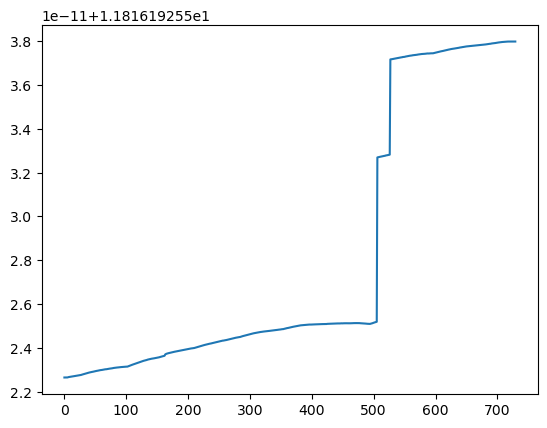

In [6]:
#w = np.ones(len(metric) - 1)
cvx_hat, cvx_seas = cvx_sd(metric, c1=100, c2=200, tv_weights=w, use_ixs=use_ixs)
plt.plot(cvx_hat)

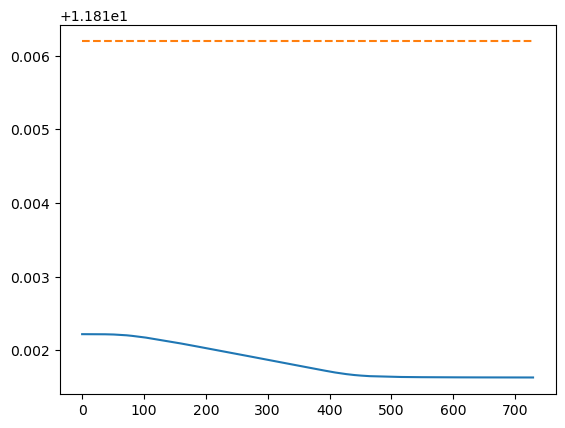

In [41]:
osd_hat, osd_seas, osd_err = osd_sd(metric, w0=5, w1=15, w2=200, solver="QSS", return_all=True, use_ixs=use_ixs)
plt.plot(osd_hat)
plt.plot(cvx_hat, linestyle="--")

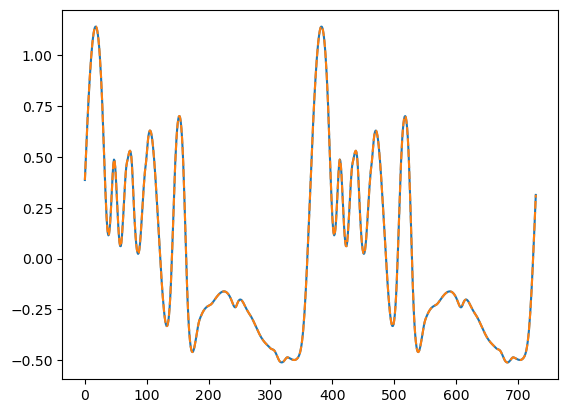

In [17]:
plt.plot(osd_seas)
plt.plot(cvx_seas, linestyle="--")